In [1]:
# package imports
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [2]:
gss = pd.read_csv('Data/gss18.csv', low_memory=False)

In [3]:
interesting_variables = ['LONELY2', 'SATJOB', 'MOREDAYS', 'WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC', 'AGE','MARITAL', 'EDUC']
# testing ridding of s
# GSS rid of HOMPOP, will HOUSEHOLD SIZE use from AARP
gss = gss[interesting_variables]

## Preprocessing

In [4]:
# how many nulls?
# Loop through each column
# and check the amount of nulls.
# Only print if there are more than 0.

for col in gss.columns:
    if gss[col].isnull().sum() > 0:
        print(f'{round(gss[col].isnull().sum()/gss.shape[0],3)}%\t{gss[col].isnull().sum()} null values in {col}')

0.503%	1182 null values in LONELY2
0.259%	609 null values in SATJOB
0.403%	947 null values in MOREDAYS
0.396%	930 null values in WRKHOME
0.008%	19 null values in HLTHPHYS
0.008%	19 null values in HLTHMNTL
0.503%	1180 null values in CONWKDAY
0.503%	1182 null values in PARTLSC
0.003%	7 null values in AGE
0.001%	2 null values in MARITAL
0.001%	3 null values in EDUC


In [5]:
# recode social isolation
gss['is_si'] = gss['LONELY2'].apply(lambda x: 1 if (x == 3 or x == 4 or x == 4) else 0)

In [6]:
# bin wkdays
bins = [-1,0,7,14,21,31]#pd.IntervalIndex.from_tuples([(-1,1), (1, 7), (7, 14), (14, 21),(21,30)])


gss['MOREWEEKS'] = pd.cut(gss['MOREDAYS'],bins,labels=['0','1','2','3','4'])

In [7]:
bins = [18,29,44,59,89]#,pd.IntervaIndex.from_tuples([(18, 29), (30, 44), (45, 59),(60,89)])


gss['Age Group'] = pd.cut(gss['AGE'],bins,labels=[1,2,3,4])

####### Age group ########

In [8]:
bins= [0,11,12,15,21]
gss['EDUC'] = pd.cut(gss['EDUC'],bins,labels=[1,2,3,4])#labels=['No HS Diploma','HS Graduate','Some College','BA or Above'])
######## EDUCATION ######

## Decision Tree

In [9]:
clf = DecisionTreeClassifier(random_state=0)

In [10]:
gss = gss.dropna()
for colm in gss.columns:
    print(f'{colm}: \t{gss[colm].unique()}')

LONELY2: 	[2. 3. 1. 4. 5.]
SATJOB: 	[1. 2. 3. 4.]
MOREDAYS: 	[ 2.  1. 24.  3.  6.  0. 15. 30. 20. 12. 18.  5.  4. 10. 26. 25.  8. 28.
  7. 17. 22. 14. 23.  9. 16.]
WRKHOME: 	[1. 4. 5. 6. 2. 3.]
HLTHPHYS: 	[1. 3. 2. 4. 5.]
HLTHMNTL: 	[1. 2. 3. 4. 5.]
CONWKDAY: 	[4. 3. 2. 6. 1. 5.]
PARTLSC: 	[3. 2. 5. 1. 4.]
AGE: 	[63. 59. 43. 55. 34. 44. 40. 30. 20. 65. 46. 22. 23. 28. 37. 42. 21. 70.
 53. 29. 50. 56. 67. 54. 48. 76. 39. 69. 60. 35. 38. 26. 57. 19. 36. 61.
 33. 51. 58. 45. 52. 25. 27. 24. 77. 47. 74. 32. 31. 72. 66. 68. 49. 64.
 41. 71. 78. 75. 85. 73. 62. 89.]
MARITAL: 	[1. 3. 5. 4. 2.]
EDUC: 	[4, 3, 2, 1]
Categories (4, int64): [1 < 2 < 3 < 4]
is_si: 	[0 1]
MOREWEEKS: 	['1', '4', '0', '3', '2']
Categories (5, object): ['0' < '1' < '2' < '3' < '4']
Age Group: 	[4, 3, 2, 1]
Categories (4, int64): [1 < 2 < 3 < 4]


### make x and y

In [11]:
x = gss.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
y = gss['is_si']
x.shape

(688, 10)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)#,stratify=x['MOREWEEKS'])

In [13]:
# decision tree regular fit
clf.fit(x_train,y_train)
clf.score(x_test, y_test)

0.7017543859649122

In [14]:
# baseline
gss['is_si'].value_counts()[0]/gss['is_si'].value_counts().sum()
# 79% baseline. awkward.

0.7877906976744186

In [15]:
# 79%... what quantities?
gss['is_si'].value_counts()

0    542
1    146
Name: is_si, dtype: int64

In [30]:
# prepare grid search
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'max_leaf_nodes': range(2,1000,22),
    'max_features': ['auto', 'sqrt', 'log2'], # all of the feature types
    'max_depth' : range(1,100, 5), # again, steps of 25
    'criterion' :['gini', 'entropy', 'log_loss'], # the two common criterion 
    'max_features': ['sqrt', 'log2', None]
}

In [31]:
# do the grid search
CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1) 
CV_DT.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 100, 5),
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': range(2, 1000, 22)})

In [18]:
CV_DT.score(x_test, y_test)

0.7982456140350878

In [37]:
x.head()

,SATJOB,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,MARITAL,EDUC,MOREWEEKS,Age Group
29,1.0,1.0,1.0,1.0,2.0,1.0,5.0,3,1,1
50,1.0,6.0,1.0,2.0,3.0,5.0,5.0,3,1,1
58,3.0,1.0,4.0,3.0,4.0,2.0,5.0,1,0,1
59,2.0,1.0,5.0,3.0,2.0,5.0,4.0,1,1,1
74,2.0,1.0,4.0,2.0,5.0,2.0,5.0,3,1,1


## upsampling is_si

In [19]:
to_resample = gss.loc[gss['is_si'] ==1]
our_resample = to_resample.sample(n = 396, replace = True)
gss_rebal = pd.concat([gss, our_resample])

In [20]:
x = gss_rebal.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
y = gss_rebal['is_si']
x.shape

(1084, 10)

In [21]:
gss_rebal['is_si'].value_counts()

0    542
1    542
Name: is_si, dtype: int64

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [23]:
clf.fit(x_train,y_train)
clf.score(x_test, y_test)

0.8575418994413407

In [24]:
param_grid = { 
    'max_leaf_nodes': range(2,1000,22),
    'max_features': ['auto', 'sqrt', 'log2'], # all of the feature types
    'max_depth' : range(1,100, 5), # again, steps of 25
    'criterion' :['gini', 'entropy', 'log_loss'], # the two common criterion 
    'max_features': ['sqrt', 'log2', None]
}

In [25]:
CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1) 
CV_DT.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 100, 5),
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': range(2, 1000, 22)})

In [26]:
CV_DT.score(x_test, y_test)

0.8435754189944135

In [27]:
x.shape

(1084, 10)

In [28]:
for importance, feature in zip(clf.feature_importances_, clf.feature_names_in_):
    print(f'{round(importance,3)}\t{feature}')

0.073	SATJOB
0.082	WRKHOME
0.112	HLTHPHYS
0.182	HLTHMNTL
0.11	CONWKDAY
0.094	PARTLSC
0.08	MARITAL
0.074	EDUC
0.088	MOREWEEKS
0.104	Age Group


In [29]:
# DT for each age category
for ages in gss['Age Group'].unique():
    print(f'---------- ages {ages}-----------')
    age_gss = gss_rebal.loc[gss_rebal['Age Group'] == ages]
    x = age_gss.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
    y = age_gss['is_si']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    clf.fit(x_train,y_train)
    print(f'{round(clf.score(x_test, y_test),3)}% {ages}')
    
    for importance, feature in zip(clf.feature_importances_, clf.feature_names_in_):
        print(f'{round(importance,3)}\t{feature}')

---------- ages 4-----------
0.86% 4
0.061	SATJOB
0.122	WRKHOME
0.094	HLTHPHYS
0.24	HLTHMNTL
0.149	CONWKDAY
0.0	PARTLSC
0.108	MARITAL
0.037	EDUC
0.189	MOREWEEKS
0.0	Age Group
---------- ages 3-----------
0.802% 3
0.045	SATJOB
0.045	WRKHOME
0.168	HLTHPHYS
0.355	HLTHMNTL
0.104	CONWKDAY
0.1	PARTLSC
0.084	MARITAL
0.062	EDUC
0.038	MOREWEEKS
0.0	Age Group
---------- ages 2-----------
0.862% 2
0.057	SATJOB
0.126	WRKHOME
0.101	HLTHPHYS
0.144	HLTHMNTL
0.064	CONWKDAY
0.178	PARTLSC
0.147	MARITAL
0.068	EDUC
0.115	MOREWEEKS
0.0	Age Group
---------- ages 1-----------
0.784% 1
0.09	SATJOB
0.052	WRKHOME
0.117	HLTHPHYS
0.095	HLTHMNTL
0.221	CONWKDAY
0.083	PARTLSC
0.123	MARITAL
0.176	EDUC
0.043	MOREWEEKS
0.0	Age Group


In [39]:
from sklearn import tree
import matplotlib.pyplot as plt 

[Text(0.45072115384615385, 0.95, 'MARITAL <= 2.0\ngini = 0.486\nsamples = 149\nvalue = [62, 87]\nclass = WRKHOME'),
 Text(0.3125, 0.85, 'WRKHOME <= 4.5\ngini = 0.124\nsamples = 15\nvalue = [14, 1]\nclass = SATJOB'),
 Text(0.27403846153846156, 0.75, 'gini = 0.0\nsamples = 14\nvalue = [14, 0]\nclass = SATJOB'),
 Text(0.35096153846153844, 0.75, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = WRKHOME'),
 Text(0.5889423076923077, 0.85, 'CONWKDAY <= 3.5\ngini = 0.46\nsamples = 134\nvalue = [48, 86]\nclass = WRKHOME'),
 Text(0.42788461538461536, 0.75, 'SATJOB <= 2.5\ngini = 0.5\nsamples = 63\nvalue = [32, 31]\nclass = SATJOB'),
 Text(0.3173076923076923, 0.65, 'HLTHPHYS <= 3.5\ngini = 0.469\nsamples = 48\nvalue = [30, 18]\nclass = SATJOB'),
 Text(0.21153846153846154, 0.55, 'EDUC <= 1.5\ngini = 0.399\nsamples = 40\nvalue = [29, 11]\nclass = SATJOB'),
 Text(0.11538461538461539, 0.45, 'HLTHPHYS <= 2.5\ngini = 0.219\nsamples = 8\nvalue = [1, 7]\nclass = WRKHOME'),
 Text(0.07692307692307693, 0.35

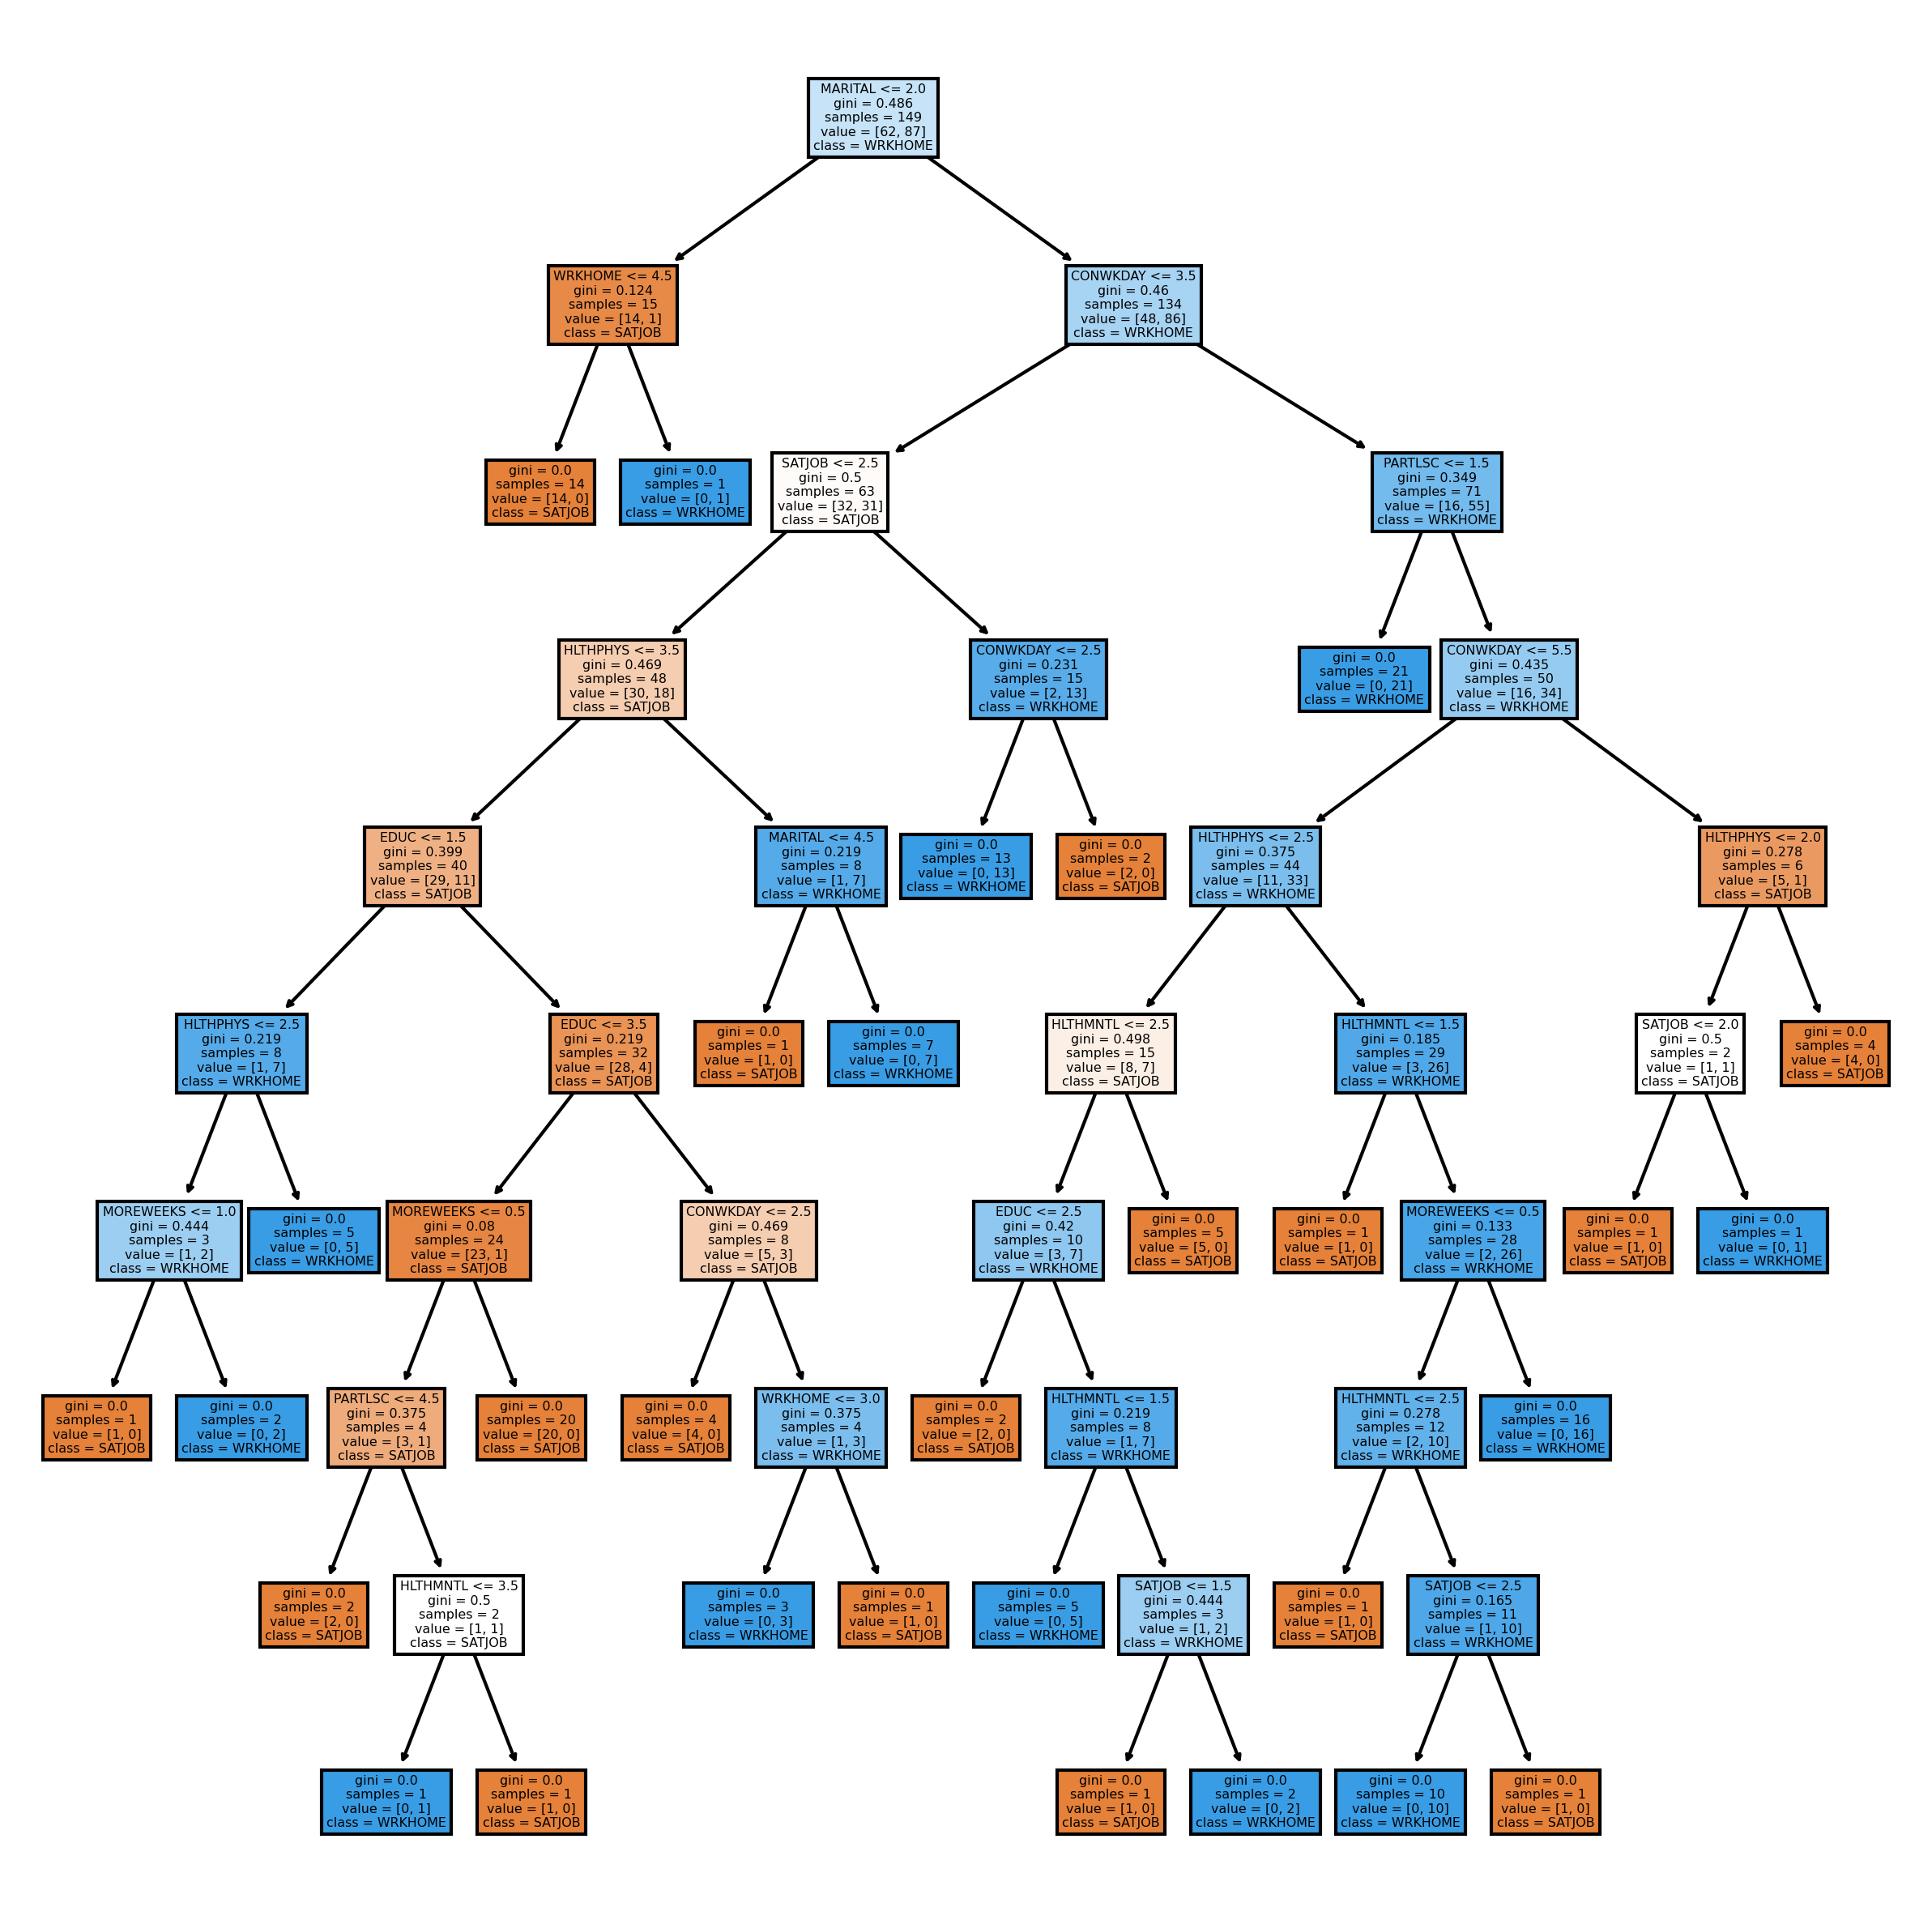

In [42]:
fix, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10), dpi=300)
tree.plot_tree(CV_DT.best_estimator_, feature_names = x.columns, class_names = CV_DT.feature_names_in_, filled = True)

In [ ]:
# upsample training data only
# fix tree????
# trim down unncessary vars?
# make output legible

# linear 